In [2]:
import h5py as h5
from math import sqrt,pi
import numpy as np
import matplotlib.pyplot as plt
from plot_settings import plotparams
from kinematic_functions import zed#qsq,k,wl
from BGL import phi#,blaschke
#from scipy.optimize import minimize_scalar
import time
import masses
from tqdm import tqdm
from numba import jit

In [3]:
#plt.rcParams.update(plotparams)

In [4]:
@jit(nopython=True)
def ggzprod(zi,zj):
    """
    inner product <g_s|g_t>
    """
    return 1.0/(1.0-zi*zj)

In [5]:
@jit(nopython=True)
def Gmatrix(zl):
    """
    G matrix for values of z in list zl
    """
    npts=len(zl)
    G=np.zeros((npts,npts))
    for i,zi in enumerate(zl):
        G[i,i]=ggzprod(zi,zi)
        for j in range(i+1,npts):
            G[i,j]=ggzprod(zi,zl[j])
            G[j,i]=G[i,j]
    return G

In [6]:
# light mesons
mpi=(2*0.13957061+0.1349770)/3 # PDG2018
mK=(0.493677+0.497611)/2       # PDG2018

# B mesons
mB=(5.27933+5.27964)/2
mBstar= 5.32470
mBs=5.36682
mBstar0plus=5.63

tp=(mBs+mK)**2
tm=(mBs-mK)**2 # = qsqmax
tcut=(mB+mpi)**2
t0=tcut-sqrt(tcut*(tcut-tm))# D mesons

etaBsK=1
chi1minusBsK=6.03e-4
chi0plusBsK=1.48e-2
fpluspoles=np.array([mBstar])
fzeropoles=np.array([])

zmax=zed(0,tcut,t0)

# z-values for pole positions
zpluspole=zed(mBstar**2,tcut,t0)
#zzeropole=zed(mBstar0plus**2,tcut,t0) # mBstar0plus is above threshold
#nplus=2 # number of input values for f+
#nzero=3 # number of input values for f0
#qsqmin='17.50' # (17.50,18.,00,18.50,19.00)
path=''


In [7]:
def compute_bounds(tl,fpinputs,fzinputs):
    """Compute dispersive bounds at a list of t = qsq values given input
        data on f+ and f0
        tl : one or a list of t values
        fpinputs = (tinl,fl,chi)
            tinl : t-values where form factor f+ is known
            fl : corresponind f+ form factor values
            chi : chi for f+
            zpole : pole location for f+
        fzinputs = (zl,fl,chi)
            zl : z-values where form factor f0 is known
            fl : corresponind f0 form factor values
            chi : chi for f0
            zpole : pole location for f0

        returns 1D array fp,dfp,fz,dfz if tl is a single value
        returns array of shape (nt,4) if tl has nt values
        returns np.array([0,0,0,0]) if unitarity check on inputs fails
    """
    tpin,fpin,chip,zppole=fpinputs
    tzin,fzin,chiz,zzpole=fzinputs
    zpin=zed(tpin,tcut,t0)
    zzin=zed(tzin,tcut,t0)

    #phifp=phi(tin,3,2,tcut,t0,tm,(eta,48.0*pi,1.0))*blaschke(tin,tcut,fpluspoles)*fpin
    #phifz=phi(tin,1,1,tcut,t0,tm,(eta,16.0*pi/(tp*tm),1.0))*blaschke(tin,tcut,fzeropoles)*fzin
    # if only one pole for each form factor, calculate Blaschke factors more directly
    Fp=phi(tpin,3,2,tcut,t0,tm,(etaBsK,48.0*pi,1.0))*((zpin-zppole)/(1.0-zpin*zppole))*fpin
    #Fz=phi(tzin,1,1,tcut,t0,tm,(eta,16.0*pi/(tp*tm),1.0))*((zzin-zzpole)/(1.0-zzin*zzpole))*fzin
    Fz=phi(tzin,1,1,tcut,t0,tm,(etaBsK,16.0*pi/(tp*tm),1.0))*fzin

    dil=[np.prod((1.0-z*np.delete(zpin,i))/(z-np.delete(zpin,i))) for i,z in enumerate(zpin)]
    Fpdl=Fp*dil*(1.0-zpin**2)
    Gp=Gmatrix(zpin)
    chimchibarp=chip-np.dot(Fpdl,np.dot(Gp,Fpdl)) # should be positive
    if chimchibarp<0.0:
        #print('unitarity failed for f+ inputs: ',chimchibarp)
        return np.array([0,0,0,0])

    dil=[np.prod((1.0-z*np.delete(zzin,i))/(z-np.delete(zzin,i))) for i,z in enumerate(zzin)]
    Fzdl=Fz*dil*(1.0-zzin**2)
    Gz=Gmatrix(zzin)
    chimchibarz=chiz-np.dot(Fzdl,np.dot(Gz,Fzdl)) # should be positive
    if chimchibarz<0.0:
        #print('unitarity failed for f0 inputs: ',chimchibarz)
        return np.array([0,0,0,0])

    # start t- and z0-dependent stuff
    if type(tl)==float:
        tl=[tl]
    boundsl=np.zeros((len(tl),4))
    for i,t in enumerate(tl):
        z0=zed(t,tcut,t0)

        jot=1.0e-6
        dtl=np.abs(t-tpin)
        if np.min(dtl)<jot: # numerically avoid problems it t is one of the input t-values
            fp,dfp=fpin[np.argmin(dtl)],0.0
        else:
            d0=np.prod((1.0-z0*zpin)/(z0-zpin))
            phipt=phi(t,3,2,tcut,t0,tm,(etaBsK,48.0*pi,1.0))*((z0-zppole)/(1.0-z0*zppole))
            fp,dfp=(-np.dot(Fpdl,1.0/(zpin-z0))/d0,
                    sqrt(chimchibarp/(1-z0*z0))/abs(d0))/phipt

        dtl=np.abs(t-tzin)
        if np.min(dtl)<jot:
            fz,dfz=fzin[np.argmin(dtl)],0.0
        else:
            d0=np.prod((1.0-z0*zzin)/(z0-zzin))
            #phizt=phi(t,1,1,tcut,t0,tm,(eta,16.0*pi/(tp*tm),1.0))*((z0-zzpole)/(1.0-z0*zzpole))
            phizt=phi(t,1,1,tcut,t0,tm,(etaBsK,16.0*pi/(tp*tm),1.0))
            fz,dfz=(-np.dot(Fzdl,1.0/(zzin-z0))/d0,
                    sqrt(chimchibarz/(1-z0*z0))/abs(d0))/phizt

        boundsl[i]=fp,dfp,fz,dfz

    if boundsl.shape==(1,4):
        return boundsl[0]
    else:
        return boundsl

In [8]:
def ff_E(Evec,pole,coeff):
  # construct ff from HMChPT in continuum limit
  return [1./(E+pole)*np.sum([E**i*coeff[i] for i in range(len(coeff))]) for E in Evec]

In [9]:
def cov_ff_p0(Evec_p,Evec_0,C,Np,N0,pole_p,pole_0):
  # construct covariance matrix for ff from HMChPT in continuum limit
  Y_E_p_vec   	= lambda E_p: np.r_[ np.array([1./(E_p+pole_p)*E_p**i for i in range(Np)])]
  Y_E_0_vec   	= lambda E_0: np.r_[ np.array([1./(E_0+pole_0)*E_0**i for i in range(N0)])]
  Cpp		= np.array([[np.dot(Y_E_p_vec(E1),np.dot(C[:Np,:Np],Y_E_p_vec(E2)))
					for E1 in Evec_p] for E2 in Evec_p])
  C00		= np.array([[np.dot(Y_E_0_vec(E1),np.dot(C[Np:,Np:],Y_E_0_vec(E2)))
					for E1 in Evec_0] for E2 in Evec_0])
  Cp0		= np.array([[np.dot(Y_E_p_vec(E1),np.dot(C[:Np:,Np:],Y_E_0_vec(E2)))
					for E1 in Evec_p] for E2 in Evec_0])
  M0		= np.r_['-1',Cpp  ,Cp0.T]
  M1		= np.r_['-1',Cp0  ,C00  ]
  M		= np.r_[M0,M1]
  return M

In [10]:
# define kinematics
mKphys		= masses.mK
mBsphys		= masses.mBs

In [11]:
# def bounds_from_2input_q2(plustlist1,zerotlist1,plustlist2,zerotlist2,nboot=2000,toutl=np.linspace(0.0,tm,10)):
#     nplus1 = len(plustlist1)
#     nplus2 = len(plustlist2)
#     nplus = len(plustlist1) + len(plustlist2)
#     nzero1 = len(zerotlist1)
#     nzero2 = len(zerotlist2)
#     nzero = len(zerotlist1) + len(zerotlist2)
#     plustlist = np.append(plustlist1,plustlist2)
#     zerotlist = np.append(zerotlist1,zerotlist2)
#     #
#     qsq_refK_plus	= np.array(plustlist1)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
#     qsq_refK_zero	= np.array(zerotlist1)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
#     qsq_refK_plus2	= np.array(plustlist2)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
#     qsq_refK_zero2	= np.array(zerotlist2)
#     #
#     ksq_refK_plus 	= (mBsphys**4+(mKphys**2-qsq_refK_plus)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus))/(4*mBsphys**2)
#     ksq_refK_zero 	= (mBsphys**4+(mKphys**2-qsq_refK_zero)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero))/(4*mBsphys**2)
    
#     ksq_refK_plus2 	= (mBsphys**4+(mKphys**2-qsq_refK_plus2)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus2))/(4*mBsphys**2)
#     ksq_refK_zero2 	= (mBsphys**4+(mKphys**2-qsq_refK_zero2)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero2))/(4*mBsphys**2)
    
#     ErefK_plus 	 	= np.sqrt(mKphys**2+ksq_refK_plus)
#     ErefK_zero 	 	= np.sqrt(mKphys**2+ksq_refK_zero)
#     ErefK_plus2 	 	= np.sqrt(mKphys**2+ksq_refK_plus2)
#     ErefK_zero2 	 	= np.sqrt(mKphys**2+ksq_refK_zero2)
    
#     Deltapar	= + 0.263
#     Deltaperp	= - 0.0416


#     f=h5.File('BstoK_ref_ff_dat.hdf5','r')
#     cp_BstoK=np.array(f.get('cp'))
#     c0_BstoK=np.array(f.get('c0'))
#     Cp0_BstoK=np.array(f.get('Cp0'))
    
#     fp_BstoK 	= np.array(ff_E(ErefK_plus,Deltaperp,cp_BstoK))
#     f0_BstoK 	= np.array(ff_E(ErefK_zero,Deltapar ,c0_BstoK))
#     ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
#     Cp0_ref 	= cov_ff_p0(ErefK_plus,ErefK_zero,Cp0_BstoK,2,3,Deltaperp,Deltapar)
    
#     fp_BstoK2 	= np.array(ff_E(ErefK_plus2,Deltaperp,cp_BstoK))
#     f0_BstoK2 	= np.array(ff_E(ErefK_zero2,Deltapar ,c0_BstoK))
#     ff_ref2		= np.r_[ fp_BstoK2, f0_BstoK2]
#     Cp0_ref2 	= cov_ff_p0(ErefK_plus2,ErefK_zero2,Cp0_BstoK,2,3,Deltaperp,Deltapar)

#     bskpts1 = np.r_[fp_BstoK,f0_BstoK]
#     bskcov1 = np.array(Cp0_ref)
#     bskpts2 = np.r_[fp_BstoK2,f0_BstoK2]
#     bskcov2 = np.array(Cp0_ref2)

#     qsqinputl = np.append(plustlist,zerotlist)
#     qsqinputl1 = np.append(plustlist1,zerotlist1)
#     qsqinputl2 = np.append(plustlist2,zerotlist2)

#     zinputl=zed(qsqinputl1,tcut,t0)
#     zinput2=zed(qsqinputl2,tcut,t0)

#     npts1=len(bskpts1)
#     npts2=len(bskpts2)
    
#     dbsk1=np.sqrt(bskcov1.diagonal())
#     bskcov1=0.5*(bskcov1 + np.transpose(bskcov1))
    
#     dbsk2=np.sqrt(bskcov2.diagonal())
#     bskcov2=0.5*(bskcov2 + np.transpose(bskcov2))
#     print(bskcov1)
#     print(bskcov2)
    
#     bskcov = np.zeros((nplus+nzero,nplus+nzero))
    
#     bskcov[0:nplus1,0:nplus1] = bskcov1[0:nplus1,0:nplus1]
#     bskcov[nplus1:nplus1+nplus2,nplus1:nplus1+nplus2] = bskcov2[0:nplus2,0:nplus2]
#     bskcov[nplus1+nplus2:nplus1+nplus2+nzero1,nplus1+nplus2:nplus1+nplus2+nzero1] = bskcov1[-nzero1:,-nzero1:]
#     bskcov[nplus1+nplus2+nzero1:nplus1+nplus2+nzero1+nzero2,nplus1+nplus2+nzero1:nplus1+nplus2+nzero1+nzero2] = bskcov2[-nzero2:,-nzero2:]
    
#     bskcov[0:nplus1,nplus1+nplus2:nplus1+nplus2+nzero1] = bskcov1[0:nplus1,-nzero1:]
#     bskcov[nplus1+nplus2:nplus1+nplus2+nzero1,0:nplus1] = bskcov1[-nzero1:,0:nplus1]
    
#     bskcov[nplus1:nplus1+nplus2,nplus1+nplus2+nzero1:nplus1+nplus2+nzero1+nzero2] = bskcov2[0:nplus2,-nzero2:]
#     bskcov[nplus1+nplus2+nzero1:nplus1+nplus2+nzero1+nzero2,nplus1:nplus1+nplus2] = bskcov2[-nzero2:,0:nplus2]
    
    
#     bskpts = np.concatenate([bskpts1[:nplus1],bskpts2[:nplus2],bskpts1[-nzero1:],bskpts2[-nzero1:]])
#     dbsk=np.sqrt(bskcov.diagonal())
    
#     print(len(bskpts))
#     # input f+ and f0 values
#     tpin=qsqinputl[:nplus]
#     zpin=zed(tpin,tcut,t0)
#     fpin=bskpts[:nplus]
#     dfpin=dbsk[:nplus]
#     tzin=qsqinputl[nplus:]
#     zzin=zed(tzin,tcut,t0)
#     fzin=bskpts[nplus:]
#     dfzin=dbsk[nplus:]
#     nppts=len(zpin)
#     nzpts=len(zzin)

#     # print('Inputs: first for f+ then f0')
#     # with np.printoptions(precision=4,floatmode='fixed',
#     #                       formatter={'float_kind':lambda x: '{:6.4f}'.format(x)}):
#     #     print('t=q^2',tpin,tzin)
#     #     print('z(t) ',zpin,zzin)
#     #     print('f+/0 ',fpin,fzin)
#     #     print('df+/0',dfpin,dfzin)
#     # print('')

    
    

#     fpinputs=(tpin,fpin,chi1minusBsK,zpluspole)
#     fzinputs=(tzin,fzin,chi0plusBsK,zpluspole) # !!! zpluspole just a dummy here
#     print(fpinputs)
#     print(fzinputs)
#     fp,dfp,fz,dfz=compute_bounds(0.0,fpinputs,fzinputs)
#     # print('bounds at t = qsq = 0')
#     # print('fplus_high {:11.9f},  fplus_low {:11.9f}'.format(fp+dfp,fp-dfp))
#     # print('fzero_high {:11.9f},  fzero_low {:11.9f}'.format(fz+dfz,fz-dfz))
#     # print('')



#     # bootstrapping for f+(0) = f0(0)

#     start=time.time()
    
    
#     ffsamp=np.random.multivariate_normal(bskpts,bskcov,size=nboot)
#     chi1m=chi1minusBsK
#     chi0p=chi0plusBsK


#     bounds0l=[] # to accumulate bounds for f+(0) = f0(0)
#     bounds0indices=[] # keep list of indices of samples which give a bound
#     nboottilde=0
#     nbootstar=0
#     for i,samp in enumerate(ffsamp):
#         fpi=samp[:nplus]
#         fzi=samp[nplus:]
#         #chi1m=chi1minus
#         #chi0p=chi0plus

#         fpinputs=(tpin,fpi,chi1m,zpluspole)
#         fzinputs=(tzin,fzi,chi0p,zpluspole)

#         shark=compute_bounds(0.0,fpinputs,fzinputs)

#         if shark.all()==False: # inputs don't satisfy unitarity
#             pass
#         else:
#             nboottilde+=1
#             fp,dfp,fz,dfz=shark
#             if fp+dfp<=fz-dfz or fz+dfz<=fp-dfp:
#                 pass
#             else: # if pass both checks record f(0) bounds and sample index
#                 nbootstar+=1
#                 bounds0l.append((fp,dfp,fz,dfz))
#                 bounds0indices.append(i)

#     # print('Nboot      = {:d} samples to generate f+(0) = f0(0)'.format(nboot))
#     # print('Nboottilde = {:d} ({:.1f} %) passed unitarity check'.format(nboottilde,
#     #                                                                     100.0*nboottilde/nboot))
#     # print('Nbootstar  = {:d} ({:.1f} %) passed kinematic constraint'.format(nbootstar,
#     #                                                                         100.0*nbootstar/nboot))
#     # print('')



#     # now do inner bootstrap on each of the nbootstar events

#     # values of t = qsq where we want to evaluate bounds
    
#     ntout=len(toutl)

#     # for inner bootstrap
#     n0=2
#     # print('N0         = {:d} for inner bootstrap'.format(n0))
#     # print('')

#     results=np.zeros((ntout,4,nbootstar))
#     for i,bounds0 in enumerate(bounds0l):

#         fp,dfp,fz,dfz=bounds0
#         fpup,fplo,fzup,fzlo=fp+dfp,fp-dfp,fz+dfz,fz-dfz
#         fstarup=min(fp+dfp,fz+dfz)
#         fstarlo=max(fp-dfp,fz-dfz)
#         index=bounds0indices[i]
#         fpi=ffsamp[index,:nplus]
#         fzi=ffsamp[index,nplus:]
#         tpin_inner=np.concatenate(([0.0],tpin))
#         tzin_inner=np.concatenate(([0.0],tzin))
#         # sample uniformly
#         #fstarsamp=np.random.uniform(fstarlo,fstarup,size=n0)
#         # or use n0 equally-spaced values (n0=2 gives just the endpoints)
#         jot=1.0e-9
#         fstarsamp=np.linspace(fstarlo+jot,fstarup-jot,n0)
#         boundsinner=np.zeros((n0,ntout,4))
#         for j,fstar in enumerate(fstarsamp):
#             fpinner=np.concatenate(([fstar],fpi))
#             fzinner=np.concatenate(([fstar],fzi))
#             fpinputs_inner=(tpin_inner,fpinner,chi1m,zpluspole)
#             fzinputs_inner=(tzin_inner,fzinner,chi0p,zpluspole)

#             boundsinner[j]=compute_bounds(toutl,fpinputs_inner,fzinputs_inner)

#         fpbarup=np.max(boundsinner[:,:,0]+boundsinner[:,:,1],axis=0)
#         fpbarlo=np.min(boundsinner[:,:,0]-boundsinner[:,:,1],axis=0)
#         fzbarup=np.max(boundsinner[:,:,2]+boundsinner[:,:,3],axis=0)
#         fzbarlo=np.min(boundsinner[:,:,2]-boundsinner[:,:,3],axis=0)
#         results[:,0,i]=fpbarup
#         results[:,1,i]=fpbarlo
#         results[:,2,i]=fzbarup
#         results[:,3,i]=fzbarlo

#     stop=time.time()
#     dt=stop-start
#     # print('Time taken: {:d}m{:d}s'.format(int(dt//60),round(dt-60*(dt//60))))
#     # print('')

#     #print(toutl)
#     raven=results.mean(axis=2)
#     fplus=(raven[:,0]+raven[:,1])/2
#     fzero=(raven[:,2]+raven[:,3])/2
#     fplusup,fpluslo=raven[:,0],raven[:,1]
#     fzeroup,fzerolo=raven[:,2],raven[:,3]
#     covplus=np.array([np.cov(arg[:2],ddof=1) for arg in results])
#     covzero=np.array([np.cov(arg[2:],ddof=1) for arg in results])
#     sigplus=np.sqrt((fplusup-fpluslo)**2/12+(covplus[:,0,0]+covplus[:,1,1]+covplus[:,0,1])/3)
#     sigzero=np.sqrt((fzeroup-fzerolo)**2/12+(covzero[:,0,0]+covzero[:,1,1]+covzero[:,0,1])/3)
#     #print('t        f+bds       f0bds')
#     # for t,fp,fz,dfp,dfz in zip(toutl,(fplusup+fpluslo)/2.0,(fzeroup+fzerolo)/2.0,
#     #                            np.round(10000*sigplus),np.round(10000*sigzero)):
#         #print('{:7.4f}  {:.4f}({:4.0f})  {:.4f}({:4.0f})'.format(t,fp,dfp,fz,dfz))
#     return list(zip(toutl,(fplusup+fpluslo)/2.0,(fzeroup+fzerolo)/2.0,sigplus,sigzero))



In [12]:
def BstoK_data(plustlist,zerotlist):
    nplus = len(plustlist)
    nzero = len(zerotlist)
    #
    qsq_refK_plus	= np.array(plustlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
    qsq_refK_zero	= np.array(zerotlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))

    #
    ksq_refK_plus 	= (mBsphys**4+(mKphys**2-qsq_refK_plus)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus))/(4*mBsphys**2)
    ksq_refK_zero 	= (mBsphys**4+(mKphys**2-qsq_refK_zero)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero))/(4*mBsphys**2)

    ErefK_plus 	 	= np.sqrt(mKphys**2+ksq_refK_plus)
    ErefK_zero 	 	= np.sqrt(mKphys**2+ksq_refK_zero)
    Deltapar	= + 0.263
    Deltaperp	= - 0.0416


    f=h5.File('BstoK_ref_ff_dat.hdf5','r')
    cp_BstoK=np.array(f.get('cp'))
    c0_BstoK=np.array(f.get('c0'))
    Cp0_BstoK=np.array(f.get('Cp0'))
    fp_BstoK 	= np.array(ff_E(ErefK_plus,Deltaperp,cp_BstoK))
    f0_BstoK 	= np.array(ff_E(ErefK_zero,Deltapar ,c0_BstoK))
    ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
    Cp0_ref 	= cov_ff_p0(ErefK_plus,ErefK_zero,Cp0_BstoK,2,3,Deltaperp,Deltapar)

    bskpts = np.r_[fp_BstoK,f0_BstoK]
    bskcov = np.array(Cp0_ref)
    
    
    
    
    
    
    
    
    return bskpts,bskcov,plustlist,zerotlist

In [13]:
mat = np.array([[1,2,3,4],[5,6,7,8]])
print(mat[:,1:])

[[2 3 4]
 [6 7 8]]


In [16]:
def data_mixer(input1,input2):
    (data1,cov1,plustlist1,zerotlist1) = input1
    (data2,cov2,plustlist2,zerotlist2) = input2
    print("Determinant of cov1 = ",np.linalg.det(cov1))    
    print("Determinant of cov2 = ",np.linalg.det(cov2))

    totplus = np.append(data1[0:len(plustlist1)],data2[0:len(plustlist2)])
    totzero = np.append(data1[-len(zerotlist1):],data2[-len(zerotlist2):])
    plustlist = np.append(plustlist1,plustlist2)
    zerotlist = np.append(zerotlist1,zerotlist2)
    
    totdata = np.append(totplus,totzero)
    
    totcov = np.zeros((len(totplus)+len(totzero),len(totplus)+len(totzero)))
#     print("totplus is ",totplus)
#     print("totzero is ",totzero)
#     print("cov1 is ",cov1)
#     print("cov2 is ",cov2)
    
    for i in range(len(plustlist1)):
        for j in range(len(plustlist1)):
            totcov[i,j] = cov1[i,j]
            
    for i in range(len(plustlist2)):
        for j in range(len(plustlist2)):
            totcov[len(plustlist1)+i,len(plustlist1)+j] = cov2[i,j]
    
    for i in range(len(zerotlist1)):
        for j in range(len(zerotlist1)):
            totcov[len(plustlist1)+len(plustlist2)+i,len(plustlist1)+len(plustlist2)+j] = cov1[len(plustlist1)+i,len(plustlist1)+j]
            
    for i in range(len(zerotlist2)):
        for j in range(len(zerotlist2)):
            totcov[len(plustlist1)+len(plustlist2)+len(zerotlist1)+i,len(plustlist1)+len(plustlist2)+len(zerotlist1)+j] = cov2[len(plustlist2)+i,len(plustlist2)+j]
    
    for i in range(len(plustlist1)):
        for j in range(len(zerotlist1)):
            totcov[i,len(plustlist1)+len(plustlist2)+j] = cov1[i,len(plustlist1)+j]
            totcov[len(plustlist1)+len(plustlist2)+j,i] = cov1[j,len(plustlist1)+i]
            
    for i in range(len(plustlist2)):
        for j in range(len(zerotlist2)):
            totcov[len(plustlist1)+i,len(plustlist1)+len(plustlist2)+len(zerotlist1)+j] = cov2[i,len(plustlist2)+j]
            totcov[len(plustlist1)+len(plustlist2)+len(zerotlist1)+j,len(plustlist1)+i] = cov2[j,len(plustlist2)+i]

    print("Determinant of combined cov = ",np.linalg.det(totcov))
    #print("datasets merged successfully, output is: ",totdata,totcov,plustlist,zerotlist,"fin")
    return totdata,totcov,plustlist,zerotlist

In [17]:
plus1 = np.array([1.1])
zero1 = np.array([1.2])
data1 = np.array([[1.1],[1.2]])
cov1 = np.array([[1,2],[3,4]])
plus2 = np.array([2.1])
zero2 = np.array([2.2])
data2 = np.array([[2.1],[2.2]])
cov2 = np.array([[5,6],[7,8]])

in1 = (data1,cov1,plus1,zero1)
in2 = (data2,cov2,plus2,zero2)

print(in1,in2)
print(data_mixer(in1,in2))

(array([[1.1],
       [1.2]]), array([[1, 2],
       [3, 4]]), array([1.1]), array([1.2])) (array([[2.1],
       [2.2]]), array([[5, 6],
       [7, 8]]), array([2.1]), array([2.2]))
Determinant of cov1 =  -2.0000000000000004
Determinant of cov2 =  -1.999999999999999
Determinant of combined cov =  0.0
(array([1.1, 2.1, 1.2, 2.2]), array([[1., 0., 2., 0.],
       [0., 5., 0., 6.],
       [2., 0., 4., 0.],
       [0., 6., 0., 8.]]), array([1.1, 2.1]), array([1.2, 2.2]))


In [18]:
def BstoK_generate_data(plustlist,zerotlist):
    nplus = len(plustlist)
    nzero = len(zerotlist)
    #
    qsq_refK_plus	= np.array(plustlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
    qsq_refK_zero	= np.array(zerotlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))

    #
    ksq_refK_plus 	= (mBsphys**4+(mKphys**2-qsq_refK_plus)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus))/(4*mBsphys**2)
    ksq_refK_zero 	= (mBsphys**4+(mKphys**2-qsq_refK_zero)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero))/(4*mBsphys**2)

    ErefK_plus 	 	= np.sqrt(mKphys**2+ksq_refK_plus)
    ErefK_zero 	 	= np.sqrt(mKphys**2+ksq_refK_zero)
    Deltapar	= + 0.263
    Deltaperp	= - 0.0416


    f=h5.File('BstoK_ref_ff_dat.hdf5','r')
    cp_BstoK=np.array(f.get('cp'))
    c0_BstoK=np.array(f.get('c0'))
    Cp0_BstoK=np.array(f.get('Cp0'))
    fp_BstoK 	= np.array(ff_E(ErefK_plus,Deltaperp,cp_BstoK))
    f0_BstoK 	= np.array(ff_E(ErefK_zero,Deltapar ,c0_BstoK))
    ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
    Cp0_ref 	= cov_ff_p0(ErefK_plus,ErefK_zero,Cp0_BstoK,2,3,Deltaperp,Deltapar)

    bskpts = np.r_[fp_BstoK,f0_BstoK]
    bskcov = np.array(Cp0_ref)

    qsqinputl = np.append(plustlist,zerotlist)


    zinputl=zed(qsqinputl,tcut,t0)

    npts=len(bskpts)
    bskptslbls=[char for char in nplus*'+'+nzero*'0']

    dbsk=np.sqrt(bskcov.diagonal())
    bskcov=0.5*(bskcov + np.transpose(bskcov))
    
    return bskpts,bskcov,plustlist,zerotlist

In [19]:
def bounds_from_data(data_input,nboot=2000,toutl=np.linspace(0.0,tm,10)):
    (bskpts,bskcov,plustlist,zerotlist) = data_input
    
    nplus = len(plustlist)
    nzero = len(zerotlist)
    #print(plustlist,zerotlist)
    qsqinputl = np.append(plustlist,zerotlist)
    dbsk=np.sqrt(bskcov.diagonal())
    bskcov=0.5*(bskcov + np.transpose(bskcov))
    
    zinputl=zed(qsqinputl,tcut,t0)
    # input f+ and f0 values
    tpin=qsqinputl[:nplus]
    zpin=zed(tpin,tcut,t0)
    fpin=bskpts[:nplus]
    dfpin=dbsk[:nplus]
    tzin=qsqinputl[nplus:]
    zzin=zed(tzin,tcut,t0)
    fzin=bskpts[nplus:]
    dfzin=dbsk[nplus:]
    nppts=len(zpin)
    nzpts=len(zzin)



    fpinputs=(tpin,fpin,chi1minusBsK,zpluspole)
    fzinputs=(tzin,fzin,chi0plusBsK,zpluspole) # !!! zpluspole just a dummy here
    #print(fpinputs)
    #print(fzinputs)
    fp,dfp,fz,dfz=compute_bounds(0.0,fpinputs,fzinputs)


    start=time.time()


    ffsamp=np.random.multivariate_normal(bskpts,bskcov,size=nboot)
    chi1m=chi1minusBsK
    chi0p=chi0plusBsK


    bounds0l=[] # to accumulate bounds for f+(0) = f0(0)
    bounds0indices=[] # keep list of indices of samples which give a bound
    nboottilde=0
    nbootstar=0
    for i,samp in enumerate(ffsamp):
        fpi=samp[:nplus]
        fzi=samp[nplus:]
        #chi1m=chi1minus
        #chi0p=chi0plus

        fpinputs=(tpin,fpi,chi1m,zpluspole)
        fzinputs=(tzin,fzi,chi0p,zpluspole)

        shark=compute_bounds(0.0,fpinputs,fzinputs)

        if shark.all()==False: # inputs don't satisfy unitarity
            pass
        else:
            nboottilde+=1
            fp,dfp,fz,dfz=shark
            if fp+dfp<=fz-dfz or fz+dfz<=fp-dfp:
                pass
            else: # if pass both checks record f(0) bounds and sample index
                nbootstar+=1
                bounds0l.append((fp,dfp,fz,dfz))
                bounds0indices.append(i)

    # print('Nboot      = {:d} samples to generate f+(0) = f0(0)'.format(nboot))
    # print('Nboottilde = {:d} ({:.1f} %) passed unitarity check'.format(nboottilde,
    #                                                                     100.0*nboottilde/nboot))
    # print('Nbootstar  = {:d} ({:.1f} %) passed kinematic constraint'.format(nbootstar,
    #                                                                         100.0*nbootstar/nboot))
    # print('')



    # now do inner bootstrap on each of the nbootstar events

    # values of t = qsq where we want to evaluate bounds
    
    ntout=len(toutl)

    # for inner bootstrap
    n0=2
    # print('N0         = {:d} for inner bootstrap'.format(n0))
    # print('')

    results=np.zeros((ntout,4,nbootstar))
    for i,bounds0 in enumerate(bounds0l):

        fp,dfp,fz,dfz=bounds0
        fpup,fplo,fzup,fzlo=fp+dfp,fp-dfp,fz+dfz,fz-dfz
        fstarup=min(fp+dfp,fz+dfz)
        fstarlo=max(fp-dfp,fz-dfz)
        index=bounds0indices[i]
        fpi=ffsamp[index,:nplus]
        fzi=ffsamp[index,nplus:]
        tpin_inner=np.concatenate(([0.0],tpin))
        tzin_inner=np.concatenate(([0.0],tzin))
        # sample uniformly
        #fstarsamp=np.random.uniform(fstarlo,fstarup,size=n0)
        # or use n0 equally-spaced values (n0=2 gives just the endpoints)
        jot=1.0e-9
        fstarsamp=np.linspace(fstarlo+jot,fstarup-jot,n0)
        boundsinner=np.zeros((n0,ntout,4))
        for j,fstar in enumerate(fstarsamp):
            fpinner=np.concatenate(([fstar],fpi))
            fzinner=np.concatenate(([fstar],fzi))
            fpinputs_inner=(tpin_inner,fpinner,chi1m,zpluspole)
            fzinputs_inner=(tzin_inner,fzinner,chi0p,zpluspole)

            boundsinner[j]=compute_bounds(toutl,fpinputs_inner,fzinputs_inner)

        fpbarup=np.max(boundsinner[:,:,0]+boundsinner[:,:,1],axis=0)
        fpbarlo=np.min(boundsinner[:,:,0]-boundsinner[:,:,1],axis=0)
        fzbarup=np.max(boundsinner[:,:,2]+boundsinner[:,:,3],axis=0)
        fzbarlo=np.min(boundsinner[:,:,2]-boundsinner[:,:,3],axis=0)
        results[:,0,i]=fpbarup
        results[:,1,i]=fpbarlo
        results[:,2,i]=fzbarup
        results[:,3,i]=fzbarlo

    stop=time.time()
    dt=stop-start
    # print('Time taken: {:d}m{:d}s'.format(int(dt//60),round(dt-60*(dt//60))))
    # print('')

    #print(toutl)
    raven=results.mean(axis=2)
    fplus=(raven[:,0]+raven[:,1])/2
    fzero=(raven[:,2]+raven[:,3])/2
    fplusup,fpluslo=raven[:,0],raven[:,1]
    fzeroup,fzerolo=raven[:,2],raven[:,3]
    covplus=np.array([np.cov(arg[:2],ddof=1) for arg in results])
    covzero=np.array([np.cov(arg[2:],ddof=1) for arg in results])
    sigplus=np.sqrt((fplusup-fpluslo)**2/12+(covplus[:,0,0]+covplus[:,1,1]+covplus[:,0,1])/3)
    sigzero=np.sqrt((fzeroup-fzerolo)**2/12+(covzero[:,0,0]+covzero[:,1,1]+covzero[:,0,1])/3)
    #print('t        f+bds       f0bds')
    # for t,fp,fz,dfp,dfz in zip(toutl,(fplusup+fpluslo)/2.0,(fzeroup+fzerolo)/2.0,
    #                            np.round(10000*sigplus),np.round(10000*sigzero)):
        #print('{:7.4f}  {:.4f}({:4.0f})  {:.4f}({:4.0f})'.format(t,fp,dfp,fz,dfz))
    return list(zip(toutl,(fplusup+fpluslo)/2.0,(fzeroup+fzerolo)/2.0,sigplus,sigzero))



In [30]:
data_input = data_mixer(BstoK_generate_data([17,23],[17,23]),BstoK_generate_data([17.5],[17.5]))
bounds_from_data(data_input,nboot=2000,toutl=[0,3,6,9])

Determinant of cov1 =  1.1468408227103487e-14
Determinant of cov2 =  1.110744496638895e-07
Determinant of combined cov =  1.323938375691343e-21


[(0,
  0.15941019762861325,
  0.15941019762861325,
  0.24434612655432833,
  0.24434612655432833),
 (3,
  0.2151399190414509,
  0.19274199584473606,
  0.22039763717860286,
  0.20037246766405375),
 (6,
  0.28706518445079027,
  0.23163745467174016,
  0.19413903505250765,
  0.15600451271950805),
 (9,
  0.38342282082490475,
  0.2781015207762003,
  0.16266790887535865,
  0.11165112661278415)]

In [26]:
inputvardata = []
lowervals = np.linspace(17,20,16)
nboot=2000
for lower in tqdm(lowervals):
    inputvardata.append(bounds_from_data(data_mixer(BstoK_generate_data([lower,23],[lower,23]),BstoK_generate_data([23.5],[23.5])),nboot=2000,toutl=[0,3,6,9]))

inputvardata = np.array(inputvardata)
resultstlist = inputvardata[0,:,0]

a = np.zeros((len(resultstlist),np.shape(lowervals)[0],2))
b = np.zeros((len(resultstlist),np.shape(lowervals)[0],2))
emptyarray = []
boundsresults = []
#print(inputvardata)
for lower in range(np.shape(lowervals)[0]):
    for t in range(len(resultstlist)):
        a[t,lower] = inputvardata[lower,t,[1,3]]
        b[t,lower] = inputvardata[lower,t,[2,4]]
boundsresults = [a,b]
boundsresults = np.array(boundsresults)
zerobounds = boundsresults[0][0]

  0%|          | 0/16 [00:00<?, ?it/s]

Determinant of cov1 =  1.1468408227103487e-14
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  4.2570994192016104e-21


  6%|▋         | 1/16 [00:02<00:40,  2.69s/it]

Determinant of cov1 =  9.796633215411236e-15
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  3.66331354477002e-21


 12%|█▎        | 2/16 [00:05<00:37,  2.65s/it]

Determinant of cov1 =  8.319497523029732e-15
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  3.1369856063569664e-21


 19%|█▉        | 3/16 [00:07<00:34,  2.68s/it]

Determinant of cov1 =  7.022188898184502e-15
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  2.672871830585041e-21


 25%|██▌       | 4/16 [00:10<00:31,  2.66s/it]

Determinant of cov1 =  5.890135811766751e-15
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  2.2658505999348437e-21


 31%|███▏      | 5/16 [00:13<00:29,  2.69s/it]

Determinant of cov1 =  4.9090582319408626e-15
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  1.910938631993223e-21


 38%|███▊      | 6/16 [00:15<00:26,  2.65s/it]

Determinant of cov1 =  4.0650216877761384e-15
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  1.6033079077604944e-21


 44%|████▍     | 7/16 [00:18<00:23,  2.60s/it]

Determinant of cov1 =  3.3444944409634828e-15
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  1.3383032442315133e-21


 50%|█████     | 8/16 [00:20<00:20,  2.54s/it]

Determinant of cov1 =  2.7344074643165635e-15
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  1.1114603647213536e-21


 56%|█████▋    | 9/16 [00:23<00:17,  2.45s/it]

Determinant of cov1 =  2.2222167745377838e-15
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  9.185242696027834e-22


 62%|██████▎   | 10/16 [00:25<00:14,  2.37s/it]

Determinant of cov1 =  1.7959674788341886e-15
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  7.554676488993597e-22


 69%|██████▉   | 11/16 [00:27<00:11,  2.39s/it]

Determinant of cov1 =  1.4443586639792786e-15
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  6.185090051546085e-22


 75%|███████▌  | 12/16 [00:30<00:09,  2.45s/it]

Determinant of cov1 =  1.1568079755993713e-15
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  5.041300689203103e-22


 81%|████████▏ | 13/16 [00:32<00:07,  2.43s/it]

Determinant of cov1 =  9.23514398182822e-16
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  4.0909198913622923e-22


 88%|████████▊ | 14/16 [00:34<00:04,  2.37s/it]

Determinant of cov1 =  7.35517346885669e-16
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  3.304496663252573e-22


 94%|█████████▍| 15/16 [00:36<00:02,  2.27s/it]

Determinant of cov1 =  5.847497172964955e-16
Determinant of cov2 =  3.571578434724066e-07
Determinant of combined cov =  2.6556346878910525e-22


100%|██████████| 16/16 [00:39<00:00,  2.44s/it]


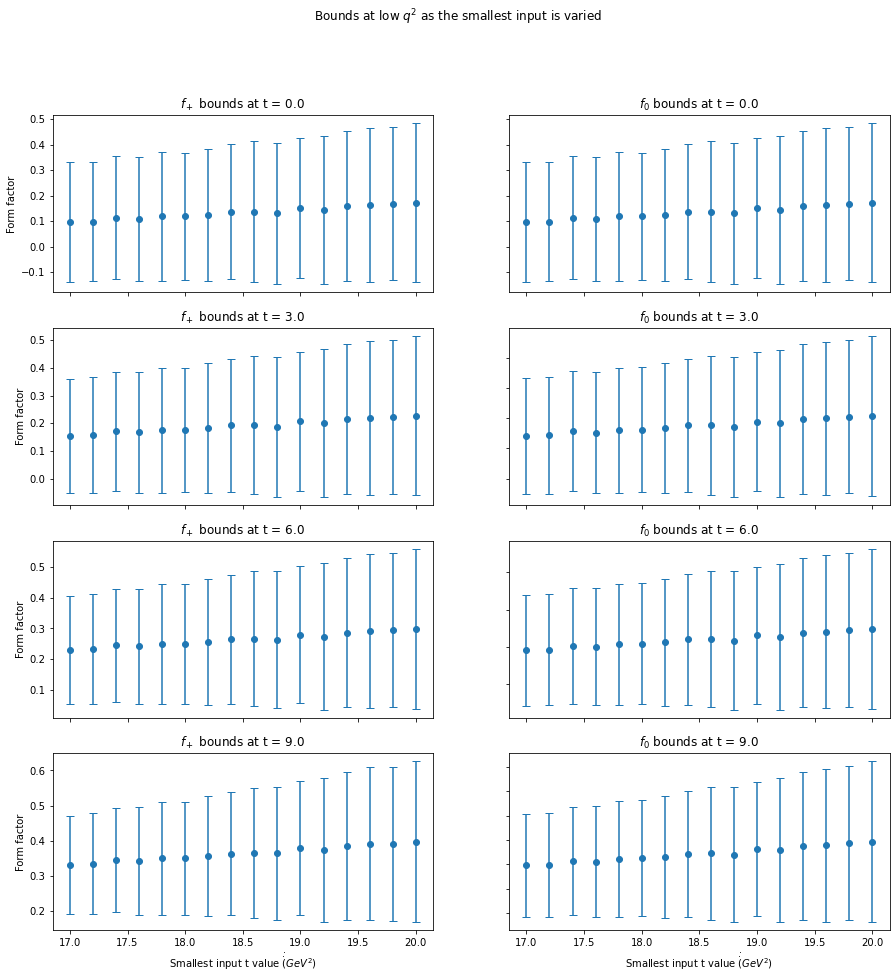

In [27]:
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(np.shape(boundsresults)[1], np.shape(boundsresults)[0],sharex=True, sharey=False)
fig.suptitle(r'Bounds at low $q^2$ as the smallest input is varied')
#colours = [str(val/np.shape(boundsresults)[2]) for val in range(np.shape(boundsresults)[2])]
for t in range(np.shape(boundsresults)[1]):
    #labelval = lowervals[t]
    for ff in range(np.shape(boundsresults)[0]):
        axs[t,ff].errorbar(lowervals[:], boundsresults[ff,t,:,0], yerr=boundsresults[ff,t,:,1], xerr=None, fmt='o',capsize=4)#,color=colours[t]label = r"{}".format(labelval)
        axs[t,ff].set_title(r"$f_{}$ bounds at t = {}".format(("+" if ff == 0 else "0"),resultstlist[t]))
        
for ax in axs.flat:
    ax.set(xlabel=r"Smallest input t value $\.\. (GeV^2)$", ylabel=r"Form factor")
        
for ax in axs.flat:
    ax.label_outer()
#plt.savefig("fferroroverrange_vs_smallestt.pdf", bbox_inches="tight")
plt.show()

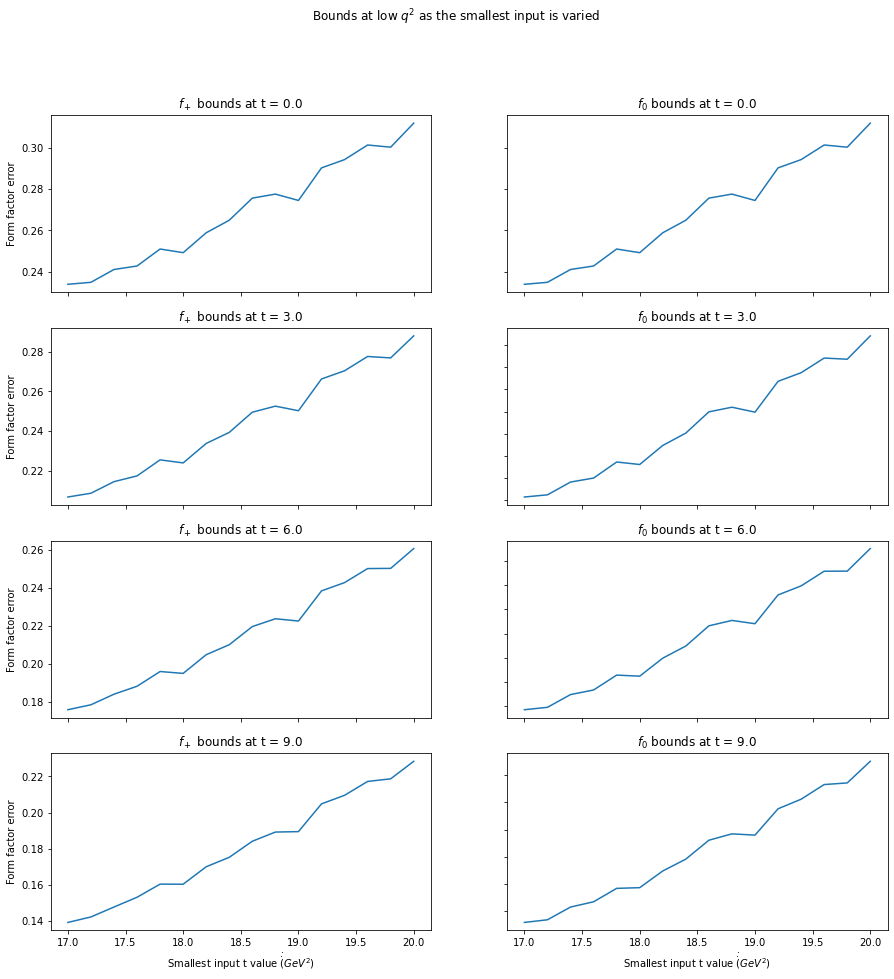

In [28]:
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(np.shape(boundsresults)[1], np.shape(boundsresults)[0],sharex=True, sharey=False)
fig.suptitle(r'Bounds at low $q^2$ as the smallest input is varied')
#colours = [str(val/np.shape(boundsresults)[2]) for val in range(np.shape(boundsresults)[2])]
for t in range(np.shape(boundsresults)[1]):
    #labelval = lowervals[t]
    for ff in range(np.shape(boundsresults)[0]):
        axs[t,ff].plot(lowervals[:], boundsresults[ff,t,:,1])
        axs[t,ff].set_title(r"$f_{}$ bounds at t = {}".format(("+" if ff == 0 else "0"),resultstlist[t]))
        
for ax in axs.flat:
    ax.set(xlabel=r"Smallest input t value $\.\. (GeV^2)$", ylabel=r"Form factor error")
        
for ax in axs.flat:
    ax.label_outer()
#plt.savefig("fferroroverrange_vs_smallestt.pdf", bbox_inches="tight")
plt.show()

In [26]:
inputvardata = []
lower = 17
midvals = np.linspace(17.1,19.9,15)
nboot=2000
for middle in tqdm(midvals):
    inputvardata.append(bounds_from_input_q2([lower,23.72835562],[lower,middle,23.72835562],nboot,np.array([0,3,6,9,12])))

inputvardata = np.array(inputvardata)
resultstlist = inputvardata[0,:,0]

a = np.zeros((len(resultstlist),np.shape(midvals)[0],2))
b = np.zeros((len(resultstlist),np.shape(midvals)[0],2))
emptyarray = []
boundsresults = []
#print(inputvardata)
for middle in range(np.shape(midvals)[0]):
    for t in range(len(resultstlist)):
        a[t,middle] = inputvardata[middle,t,[1,3]]
        b[t,middle] = inputvardata[middle,t,[2,4]]
boundsresults = [a,b]
boundsresults = np.array(boundsresults)
zerobounds = boundsresults[0][0]

100%|██████████| 15/15 [01:15<00:00,  5.02s/it]


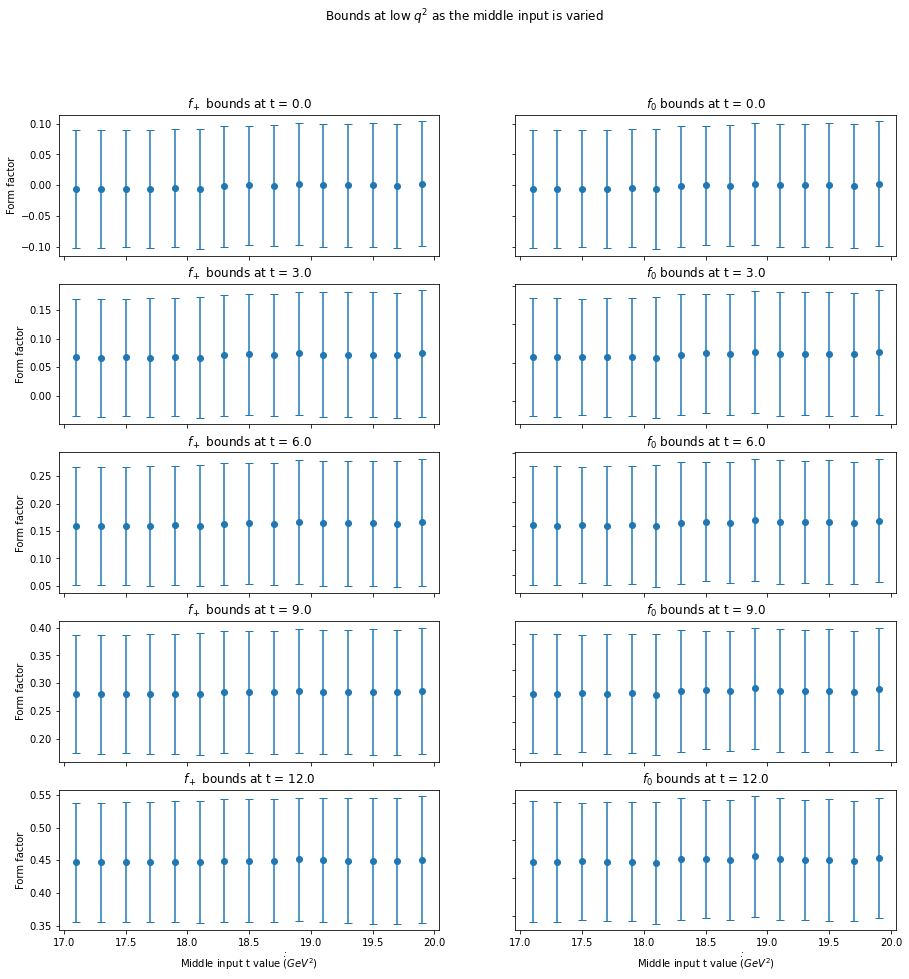

In [28]:
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(np.shape(boundsresults)[1], np.shape(boundsresults)[0],sharex=True, sharey=False)
fig.suptitle(r'Bounds at low $q^2$ as the middle input is varied')
#colours = [str(val/np.shape(boundsresults)[2]) for val in range(np.shape(boundsresults)[2])]
for t in range(np.shape(boundsresults)[1]):
    #labelval = lowervals[t]
    for ff in range(np.shape(boundsresults)[0]):
        axs[t,ff].errorbar(midvals[:], boundsresults[ff,t,:,0], yerr=boundsresults[ff,t,:,1], xerr=None, fmt='o',capsize=4)#,color=colours[t]label = r"{}".format(labelval)
        axs[t,ff].set_title(r"$f_{}$ bounds at t = {}".format(("+" if ff == 0 else "0"),resultstlist[t]))
        
for ax in axs.flat:
    ax.set(xlabel=r"Middle input t value $\.\. (GeV^2)$", ylabel=r"Form factor")
        
for ax in axs.flat:
    ax.label_outer()
#plt.savefig("fferroroverrange_vs_smallestt.pdf", bbox_inches="tight")
plt.show()

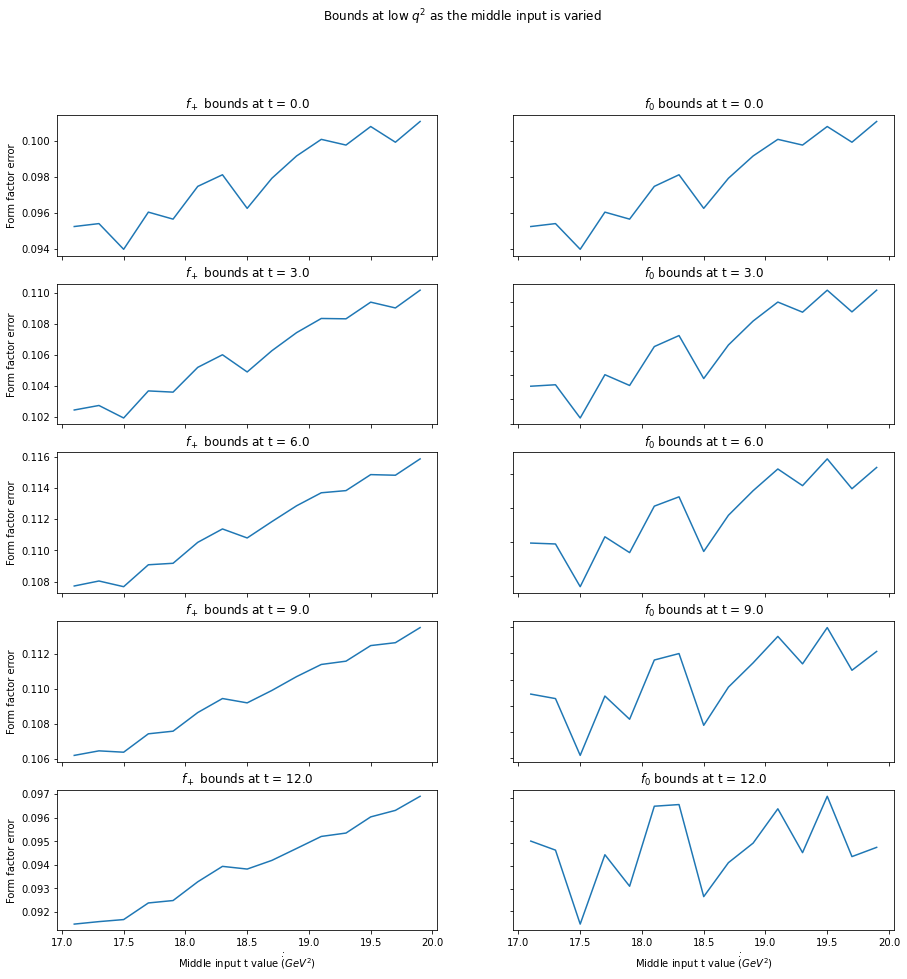

In [29]:
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(np.shape(boundsresults)[1], np.shape(boundsresults)[0],sharex=True, sharey=False)
fig.suptitle(r'Bounds at low $q^2$ as the middle input is varied')
#colours = [str(val/np.shape(boundsresults)[2]) for val in range(np.shape(boundsresults)[2])]
for t in range(np.shape(boundsresults)[1]):
    #labelval = lowervals[t]
    for ff in range(np.shape(boundsresults)[0]):
        axs[t,ff].plot(midvals[:], boundsresults[ff,t,:,1])
        axs[t,ff].set_title(r"$f_{}$ bounds at t = {}".format(("+" if ff == 0 else "0"),resultstlist[t]))
        
for ax in axs.flat:
    ax.set(xlabel=r"Middle input t value $\.\. (GeV^2)$", ylabel=r"Form factor error")
        
for ax in axs.flat:
    ax.label_outer()
#plt.savefig("fferroroverrange_vs_smallestt.pdf", bbox_inches="tight")
plt.show()